# **0.1 Imports**

In [68]:
import pandas as pd
import numpy as np
import plotly.express as px 
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots

from category_encoders         import TargetEncoder
from fast_ml.model_development import train_valid_test_split
from sklearn.metrics           import mean_absolute_error, mean_squared_error,make_scorer, mean_absolute_percentage_error
from sklearn.model_selection   import cross_val_predict, KFold, cross_val_score, cross_val_predict
from sklearn.preprocessing     import RobustScaler,MinMaxScaler,LabelEncoder
from sklearn.linear_model      import LinearRegression, Lasso
from sklearn.ensemble          import RandomForestRegressor
from xgboost                   import XGBRegressor
from catboost                  import CatBoostRegressor

## **0.1.1 Helper functions**

In [35]:
def mean_absolute_percentage_error_func(y, yhat):
    mask = y != 0
    return np.mean(np.abs(np.where(mask, (y - yhat) / y, 0)))

def mae_scorer(y_true, y_pred):
    return -mean_absolute_error(y_true, y_pred)  # Negativo porque cross_val_score espera escores mais altos

def mape_scorer(y_true, y_pred):
    return -np.mean(np.abs((y_true - y_pred) / y_true))

def mape_scorer(y_true, y_pred):
    mask = y_true != 0  # Cria uma máscara para evitar divisão por zero
    y_true_masked = y_true[mask]
    y_pred_masked = y_pred[mask]

    if len(y_true_masked) == 0:
        # Caso não haja valores diferentes de zero, retorne 0 (ou outro valor apropriado)
        return 0.0

    return -np.mean(np.abs((y_true_masked - y_pred_masked) / y_true_masked))

def rmse_scorer(y_true, y_pred):
    return -np.sqrt(mean_squared_error(y_true, y_pred))

## **0.1.2 Loading data**

In [36]:
df_raw=pd.read_csv('../datasets/raw.csv')

df_raw.head(5)

id                                              nome  host_id  \
0  2595                             Skylit Midtown Castle     2845   
1  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
2  3831                   Cozy Entire Floor of Brownstone     4869   
3  5022  Entire Apt: Spacious Studio/Loft by central park     7192   
4  5099         Large Cozy 1 BR Apartment In Midtown East     7322   

     host_name bairro_group        bairro  latitude  longitude  \
0     Jennifer    Manhattan       Midtown  40.75362  -73.98377   
1    Elisabeth    Manhattan        Harlem  40.80902  -73.94190   
2  LisaRoxanne     Brooklyn  Clinton Hill  40.68514  -73.95976   
3        Laura    Manhattan   East Harlem  40.79851  -73.94399   
4        Chris    Manhattan   Murray Hill  40.74767  -73.97500   

         room_type  price  minimo_noites  numero_de_reviews ultima_review  \
0  Entire home/apt    225              1                 45    2019-05-21   
1     Private room    150              3                  0           NaN   
2  Entire home/apt     89              1                270    2019-07-05   
3  Entire home/apt     80             10                  9    2018-11-19   
4  Entire home/apt    200              3                 74    2019-06-22   

   reviews_por_mes  calculado_host_listings_count  disponibilidade_365  
0             0.38                              2                  355  
1              NaN                              1                  365  
2             4.64                              1                  194  
3             0.10                              1                    0  
4             0.59                              1                  129

# **1 Data description**

## **1.1 Dimensions**

In [37]:
df1=df_raw.copy()

In [38]:
print(f'Number of rows:{df1.shape[0]}')
print(f'Number of cols:{df1.shape[1]}')

Number of rows:48894
Number of cols:16


## **1.2 Data types**

In [39]:
df1.dtypes

id                                 int64
nome                              object
host_id                            int64
host_name                         object
bairro_group                      object
bairro                            object
latitude                         float64
longitude                        float64
room_type                         object
price                              int64
minimo_noites                      int64
numero_de_reviews                  int64
ultima_review                     object
reviews_por_mes                  float64
calculado_host_listings_count      int64
disponibilidade_365                int64
dtype: object

### **1.2.2 Change types**

In [40]:
df1['ultima_review'] = pd.to_datetime(df1['ultima_review'])
df1['ultima_review'].dtype

dtype('<M8[ns]')

## **1.3 Check na**

In [41]:
df1.isna().sum()

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64

## **1.4 Fillout/delete na**

In [42]:
# ultima_review/reviews_por_mes
aux=df1[df1['numero_de_reviews']==0]

print(len(aux))

print(aux['ultima_review'].isna().sum())
print(aux['reviews_por_mes'].isna().sum())

aux['reviews_por_mes'].unique()

# se não há reviews, ultima_review e reviews_por_mes são vazios

10052
10052
10052


array([nan])

In [43]:
# substituir todos os NA de reviews_por_mes por 0

df1['reviews_por_mes'] = np.where(df1['reviews_por_mes'].isna(), 0, df1['reviews_por_mes'])
print(df1['reviews_por_mes'].isna().sum())
print(df1['reviews_por_mes'].min())

0
0.0


In [44]:
# ultima_review será mantida com os nans por hora, talvez seja possível excluir a variável futuramente

In [45]:
# substituir as linhas com nans em nome e host_name por 'desconhecido'

cols = ['nome','host_name']
df1[cols] = np.where(df1[cols].isna(), 'desconhecido', df1[cols])

print(df1['nome'].isna().sum())
print(df1['host_name'].isna().sum())

0
0


## **1.5 Descriptive statistics**

### **1.5.1 Numeric**

In [46]:
desc = df1.describe().T.reset_index()
desc.columns = ['attributes', 'count', 'mean', 'min', '25%', '50%%', '75%', 'max', 'std']

desc

attributes    count                           mean  \
0                              id  48894.0                19017532.130609   
1                         host_id  48894.0                67621393.581605   
2                        latitude  48894.0                      40.728951   
3                       longitude  48894.0                     -73.952169   
4                           price  48894.0                     152.720763   
5                   minimo_noites  48894.0                       7.030085   
6               numero_de_reviews  48894.0                      23.274758   
7                   ultima_review    38842  2018-10-04 01:46:50.710055936   
8                 reviews_por_mes  48894.0                       1.090928   
9   calculado_host_listings_count  48894.0                       7.144005   
10            disponibilidade_365  48894.0                     112.776169   

                    min                  25%                 50%%  \
0                2595.0           9472370.75           19677431.5   
1                2438.0           7822736.75           30795529.0   
2              40.49979              40.6901            40.723075   
3             -74.24442            -73.98307            -73.95568   
4                   0.0                 69.0                106.0   
5                   1.0                  1.0                  3.0   
6                   0.0                  1.0                  5.0   
7   2011-03-28 00:00:00  2018-07-08 00:00:00  2019-05-19 00:00:00   
8                   0.0                 0.04                 0.37   
9                   1.0                  1.0                  1.0   
10                  0.0                  0.0                 45.0   

                    75%                  max              std  
0           29152249.25           36487245.0  10982884.048876  
1           107434423.0          274321313.0  78611176.150486  
2             40.763117             40.91306         0.054529  
3            -73.936273            -73.71299         0.046157  
4                 175.0              10000.0       240.156625  
5                   5.0               1250.0        20.510741  
6                  24.0                629.0        44.550991  
7   2019-06-23 00:00:00  2019-07-08 00:00:00              NaN  
8                  1.58                 58.5         1.597294  
9                   2.0                327.0        32.952855  
10                227.0                365.0       131.618692

### **1.5.2 Categorical**

In [47]:
colunas = ['nome', 'host_name', 'bairro_group', 'bairro', 'room_type']

for coluna in colunas:
    print(f"{coluna.capitalize()}s únicos: {len(df1[coluna].unique())}")

Nomes únicos: 47905
Host_names únicos: 11453
Bairro_groups únicos: 5
Bairros únicos: 221
Room_types únicos: 3


In [48]:
fig = make_subplots(rows=1, cols=2,subplot_titles=('bairro_groups', 'room_types'))

fig.add_trace(go.Histogram(x=df1['bairro_group']),row=1, col=1)

fig.add_trace(go.Histogram(x=df1['room_type']),row=1, col=2)
fig.update_layout(showlegend=False)

fig.show()

# **<s>2 Feature engineering</s>**

In [49]:
df2=df1.copy()

## **Train, validation, test separation**

In [50]:
x_train, y_train, x_val, y_val, x_test, y_test = train_valid_test_split(df2, 
                                                        target = 'price', 
                                                        train_size=0.8, valid_size=0.1, test_size=0.1,
                                                        random_state=42)

df2=pd.concat ([x_train, y_train], axis=1).reset_index(drop=True) 

print(len(df2))
print(len(x_train))
print(len(x_val))
print(len(x_test))
print(len(y_train))
print(len(y_val))
print(len(y_test))

39115
39115
4889
4890
39115
4889
4890


# **<s>3 Variable filtering</s>**

In [51]:
df3=df2.copy()

# **4 <s>Exploratory data analysis<s/>**

In [52]:
df4=df3.copy()

# **5 Data preparation**

In [53]:
df5=df4.copy()

## **5.1 Col drops**

In [54]:
X_train=df5.drop(['id','nome','host_id','host_name','ultima_review','price'],axis=1)
y_train=df5['price']

X_val=x_val.drop(['id','nome','host_id','host_name','ultima_review'],axis=1)
X_test=x_test.drop(['id','nome','host_id','host_name','ultima_review'],axis=1)

print(len(x_train))
print(len(x_val))
print(len(x_test))

39115
4889
4890


## <s>**5.2 Histograms**<s/>

## **<s>5.3 Standardization<s/>**

## **5.4 Rescaling**

In [55]:
y_train=np.log1p(y_train) 
y_val=np.log1p(y_val)
y_test=np.log1p(y_test) 

## **5.5 Encoding**

In [56]:
# bairro_groups
X_train=pd.get_dummies(X_train,prefix=['bairro_group'],columns=['bairro_group'])
X_val=pd.get_dummies(X_val,prefix=['bairro_group'],columns=['bairro_group'])
X_test=pd.get_dummies(X_test,prefix=['bairro_group'],columns=['bairro_group'])

# room_type
X_train=pd.get_dummies(X_train,prefix=['room_type'],columns=['room_type'])
X_val=pd.get_dummies(X_val,prefix=['room_type'],columns=['room_type'])
X_test=pd.get_dummies(X_test,prefix=['room_type'],columns=['room_type'])

# bairro
te = TargetEncoder(cols=['bairro'])

X_train = te.fit_transform(X_train, y_train)
X_val = te.transform(X_val)
X_test = te.transform(X_test)

In [57]:
X_train.columns

Index(['bairro', 'latitude', 'longitude', 'minimo_noites', 'numero_de_reviews',
       'reviews_por_mes', 'calculado_host_listings_count',
       'disponibilidade_365', 'bairro_group_Bronx', 'bairro_group_Brooklyn',
       'bairro_group_Manhattan', 'bairro_group_Queens',
       'bairro_group_Staten Island', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room'],
      dtype='object')

In [58]:
# print(x_train.isna().sum())
# print(x_val.isna().sum())
# print(x_test.isna().sum())

# **6 <s>Feature selection<s/>**

In [59]:
df6=df5.copy()

# **7 Machine Learning**

In [60]:
df7=df6.copy()

## **7.1 Average model**

In [92]:
target = df7['price']

mean_prediction = target.mean()

baseline_predictions = pd.Series([mean_prediction] * len(target))

mae_baseline = mean_absolute_error(target, baseline_predictions)
mape_baseline = mean_absolute_percentage_error(target, baseline_predictions)
mse_baseline = mean_squared_error(target, baseline_predictions)
rmse_baseline = np.sqrt(mse_baseline)

result_baseline = pd.DataFrame({'Model Name': 'Baseline model',
                       'MAE': mae_baseline,
                       'MAPE': mape_baseline,
                       'RMSE': rmse_baseline}, index=[0])
result_baseline

Model Name       MAE          MAPE        RMSE
0  Baseline model  93.87391  1.593374e+14  244.152833

## **7.2 Linear regression**

In [85]:
# model
lr=LinearRegression().fit(X_train,y_train)

# prediction
lr_yhat=lr.predict(X_val)

mae_lr = mean_absolute_error(np.expm1(y_val), np.expm1(lr_yhat))
mape_lr = mean_absolute_percentage_error_func(np.expm1(y_val), np.expm1(lr_yhat))
mse_lr = mean_squared_error(np.expm1(y_val), np.expm1(lr_yhat))
rmse_lr = np.sqrt((mse_lr))

result_lr = pd.DataFrame({'Model Name': 'Linear Regression',
                       'MAE': mae_lr,
                       'MAPE': mape_lr,
                       'RMSE': rmse_lr}, index=[0])
result_lr

Model Name        MAE     MAPE        RMSE
0  Linear Regression  57.259077  0.34028  248.112382

### **7.2.1 Linear regression model - Cross validation** 

In [108]:
lr_cv = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

y_pred_log = cross_val_predict(lr_cv, X_train, y_train, cv=kf)

y_train_original = np.expm1(y_train)
y_pred_original = np.expm1(y_pred_log)

mae_lr_cv = mean_absolute_error(y_train_original, y_pred_original)
mape_lr_cv = mean_absolute_percentage_error_func(y_train_original, y_pred_original)
rmse_lr_cv = np.sqrt(mean_squared_error(y_train_original, y_pred_original))

std_mae = np.std(-mae_lr_cv)
std_mape = np.std(-mape_lr_cv)
std_rmse = np.std(-rmse_lr_cv)

result_lr_cv = pd.DataFrame({'Model Name': 'Linear Regression CV',
                              'MAE': mae_lr_cv,
                              'MAPE': mape_lr_cv,
                              'RMSE': rmse_lr_cv}, index=[0])

result_lr_cv

Model Name        MAE      MAPE        RMSE
0  Linear Regression CV  62.310637  0.350849  232.024838

## **7.3 Linear regression regularized**

In [110]:
# model
lrr=Lasso().fit(X_train,y_train)
 
# prediction
lrr_yhat=lrr.predict(X_val)

mae_lrr = mean_absolute_error(np.expm1(y_val), np.expm1(lrr_yhat))
mape_lrr = mean_absolute_percentage_error_func(np.expm1(y_val), np.expm1(lrr_yhat))
mse_lrr = mean_squared_error(np.expm1(y_val), np.expm1(lrr_yhat))
rmse_lrr = np.sqrt(mse_lrr)

result_lrr = pd.DataFrame({'Model Name': 'Lasso',
                       'MAE': mae_lrr,
                       'MAPE': mape_lrr,
                       'RMSE': rmse_lrr}, index=[0])
result_lrr

Model Name        MAE      MAPE        RMSE
0      Lasso  79.229053  0.592574  259.750174

### **7.3.1 Linear regression regularized - CV**

In [111]:
lrr_cv = Lasso()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

y_pred_log = cross_val_predict(lrr_cv, X_train, y_train, cv=kf)

y_train_original = np.expm1(y_train)
y_pred_original = np.expm1(y_pred_log)

mae_lrr_cv = mean_absolute_error(y_train_original, y_pred_original)
mape_lrr_cv = mean_absolute_percentage_error_func(y_train_original, y_pred_original)
rmse_lrr_cv = np.sqrt(mean_squared_error(y_train_original, y_pred_original))

std_mae = np.std(-mae_lrr_cv)
std_mape = np.std(-mape_lrr_cv)
std_rmse = np.std(-rmse_lrr_cv)

result_lrr_cv = pd.DataFrame({'Model Name': 'Linear Regression CV',
                              'MAE': mae_lrr_cv,
                              'MAPE': mape_lrr_cv,
                              'RMSE': rmse_lrr_cv}, index=[0])

result_lrr_cv

Model Name        MAE      MAPE        RMSE
0  Linear Regression CV  84.919907  0.613889  246.827731

## **7.4 Random Forest Regressor**

In [112]:
# model
rf=RandomForestRegressor(n_jobs=-1,random_state=95).fit(X_train,y_train)

# prediction
rf_yhat=rf.predict(X_val)

mae_rf = mean_absolute_error(np.expm1(y_val), np.expm1(rf_yhat))
mape_rf = mean_absolute_percentage_error_func(np.expm1(y_val), np.expm1(rf_yhat))
mse_rf = mean_squared_error(np.expm1(y_val), np.expm1(rf_yhat))
rmse_rf = np.sqrt(mse_rf)

result_rf = pd.DataFrame({'Model Name': 'Random Forest',
                       'MAE': mae_rf,
                       'MAPE': mape_rf,
                       'RMSE': rmse_rf}, index=[0])
result_rf

Model Name        MAE      MAPE       RMSE
0  Random Forest  55.247395  0.332264  245.35765

### **7.4.1 Random forest regressor - Cross validation** 

In [120]:
rf_cv=RandomForestRegressor(n_jobs=-1,random_state=95)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

y_pred_log = cross_val_predict(rf_cv, X_train, y_train, cv=kf)

y_train_original = np.expm1(y_train)
y_pred_original = np.expm1(y_pred_log)

mae_rf_cv = mean_absolute_error(y_train_original, y_pred_original)
mape_rf_cv = mean_absolute_percentage_error_func(y_train_original, y_pred_original)
rmse_rf_cv = np.sqrt(mean_squared_error(y_train_original, y_pred_original))

std_mae = np.std(-mae_rf_cv)
std_mape = np.std(-mape_rf_cv)
std_rmse = np.std(-rmse_rf_cv)

result_rf_cv = pd.DataFrame({'Model Name': 'Random Forest CV',
                              'MAE': mae_rf_cv,
                              'MAPE': mape_rf_cv,
                              'RMSE': rmse_rf_cv}, index=[0])

result_rf_cv

Model Name        MAE      MAPE        RMSE
0  Random Forest CV  59.176381  0.337068  225.053051

## **7.5 XGBoost regressor**

In [115]:
xgb_model=XGBRegressor(n_jobs=-1,random_state=95).fit(X_train,y_train)

# prediction
xgb_yhat=xgb_model.predict(X_val)

mae_xgb = mean_absolute_error(np.expm1(y_val), np.expm1(xgb_yhat))
mape_xgb = mean_absolute_percentage_error_func(np.expm1(y_val), np.expm1(xgb_yhat))
mse_xgb = mean_squared_error(np.expm1(y_val), np.expm1(xgb_yhat))
rmse_xgb = np.sqrt(mse_xgb)

result_xgb = pd.DataFrame({'Model Name': 'XGBoost',
                       'MAE': mae_xgb,
                       'MAPE': mape_xgb,
                       'RMSE': rmse_xgb}, index=[0])
result_xgb

Model Name        MAE      MAPE        RMSE
0    XGBoost  54.634242  0.321373  245.418648

### **7.6 XGBoost regressor - Cross validation**

In [118]:
xgb_model_cv=XGBRegressor(n_jobs=-1,random_state=95)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

y_pred_log = cross_val_predict(xgb_model_cv, X_train, y_train, cv=kf)

y_train_original = np.expm1(y_train)
y_pred_original = np.expm1(y_pred_log)

mae_xgb_cv = mean_absolute_error(y_train_original, y_pred_original)
mape_xgb_cv = mean_absolute_percentage_error_func(y_train_original, y_pred_original)
rmse_xgb_cv = np.sqrt(mean_squared_error(y_train_original, y_pred_original))

std_mae = np.std(-mae_xgb_cv)
std_mape = np.std(-mape_xgb_cv)
std_rmse = np.std(-rmse_xgb_cv)

result_xgb_cv = pd.DataFrame({'Model Name': 'XGBoost CV',
                              'MAE': mae_xgb_cv,
                              'MAPE': mape_xgb_cv,
                              'RMSE': rmse_xgb_cv}, index=[0])

result_xgb_cv

Model Name        MAE      MAPE        RMSE
0  XGBoost CV  59.115826  0.333698  224.409456

## **7.6 CatBoost regressor**

In [131]:
cat=CatBoostRegressor(logging_level='Silent').fit(X_train,y_train)

# prediction
cat_yhat=cat.predict(X_val)

mae_cat = mean_absolute_error(np.expm1(y_val), np.expm1(cat_yhat))
mape_cat = mean_absolute_percentage_error_func(np.expm1(y_val), np.expm1(cat_yhat))
mse_cat = mean_squared_error(np.expm1(y_val), np.expm1(cat_yhat))
rmse_cat = np.sqrt(mse_cat)

result_cat = pd.DataFrame({'Model Name': 'CatBoost',
                       'MAE': mae_cat,
                       'MAPE': mape_cat,
                       'RMSE': rmse_cat}, index=[0])
result_cat

Model Name        MAE      MAPE        RMSE
0   CatBoost  52.299534  0.304759  243.999673

### **7.6.1 CatBoost regressor - Cross validation**

In [132]:
cat_cv=CatBoostRegressor(logging_level='Silent')

kf = KFold(n_splits=5, shuffle=True, random_state=42)

y_pred_log = cross_val_predict(cat_cv, X_train, y_train, cv=kf)

y_train_original = np.expm1(y_train)
y_pred_original = np.expm1(y_pred_log)

mae_cat_cv = mean_absolute_error(y_train_original, y_pred_original)
mape_cat_cv = mean_absolute_percentage_error_func(y_train_original, y_pred_original)
rmse_cat_cv = np.sqrt(mean_squared_error(y_train_original, y_pred_original))

std_mae = np.std(-mae_cat_cv)
std_mape = np.std(-mape_cat_cv)
std_rmse = np.std(-rmse_cat_cv)

result_cat_cv = pd.DataFrame({'Model Name': 'CatBoost CV',
                              'MAE': mae_cat_cv,
                              'MAPE': mape_cat_cv,
                              'RMSE': rmse_cat_cv}, index=[0])

result_cat_cv

Model Name        MAE      MAPE        RMSE
0  CatBoost CV  56.844326  0.317873  220.550018

## **7.7 Compare performances**

In [129]:
modelling_result=pd.concat   ([result_baseline, result_lr,   result_lrr   ,result_rf   ,result_xgb   ,result_cat])
modelling_result_cv=pd.concat([result_baseline, result_lr_cv,result_lrr_cv,result_rf_cv,result_xgb_cv,result_cat_cv])

modelling_result.sort_values('MAE',ascending=True)

Model Name        MAE          MAPE        RMSE
0           CatBoost  53.484778  3.123978e-01  244.517180
0            XGBoost  54.634242  3.213734e-01  245.418648
0      Random Forest  55.247395  3.322640e-01  245.357650
0  Linear Regression  57.259077  3.402800e-01  248.112382
0              Lasso  79.229053  5.925738e-01  259.750174
0     Baseline model  93.873910  1.593374e+14  244.152833

## **7.8 Compare cross-validated performances**

In [130]:
modelling_result_cv.sort_values('MAE',ascending=True)

Model Name        MAE          MAPE        RMSE
0           CatBoost CV  58.196287  3.248152e-01  224.100526
0            XGBoost CV  59.115826  3.336976e-01  224.409456
0      Random Forest CV  59.176381  3.370683e-01  225.053051
0  Linear Regression CV  62.310637  3.508494e-01  232.024838
0  Linear Regression CV  84.919907  6.138890e-01  246.827731
0        Baseline model  93.873910  1.593374e+14  244.152833

## **7.9 Final model**

In [61]:
full_x = pd.concat ([X_train, X_val], axis=0,ignore_index=True) 
full_y = pd.concat ([y_train, y_val], axis=0,ignore_index=True) 

cat=CatBoostRegressor(logging_level='Silent').fit(full_x,full_y)

# prediction
cat_yhat=cat.predict(X_test)

mae_cat = mean_absolute_error(np.expm1(y_test), np.expm1(cat_yhat))
mape_cat = mean_absolute_percentage_error_func(np.expm1(y_test), np.expm1(cat_yhat))
mse_cat = mean_squared_error(np.expm1(y_test), np.expm1(cat_yhat))
rmse_cat = np.sqrt(mse_cat)

final_result_cat = pd.DataFrame({'Model Name': 'CatBoost',
                       'MAE': mae_cat,
                       'MAPE': mape_cat,
                       'RMSE': rmse_cat}, index=[0])
final_result_cat

Model Name        MAE      MAPE     RMSE
0   CatBoost  51.941602  0.307793  159.899

# <s>**8 Hyperparameter fine-tuning**<s/>

# **9 Error translation and interpretation**

In [62]:
df9=x_test.copy()
df9['price']=np.expm1(y_test)
df9['predictions']=np.expm1(cat_yhat)

## **9.1 Business performance**

In [63]:
# sum of predictions
df91=df9[['id','predictions','price']].groupby('id').sum().reset_index()             

# MAE and MAPE
df9_aux1=(df9[['id','price','predictions']].groupby('id')
          .apply(lambda x: mean_absolute_error (x['price'],x['predictions']))
          .reset_index().rename(columns={0:'MAE'}))

df9_aux2=(df9[['id','price','predictions']].groupby('id')
          .apply(lambda x: mean_absolute_percentage_error (x['price'],x['predictions']))
          .reset_index().rename(columns={0:'MAPE'}))

# merge
df9_aux3=pd.merge(df9_aux1,df9_aux2,how='inner',on='id')
df92=pd.merge(df91,df9_aux3,how='inner',on='id')

# scenarios
df92['worst_scenario']=df92['predictions'] - df92['MAE']
df92['best_scenario']=df92['predictions'] + df92['MAE']

# order columns
df92=df92[['id','price','predictions','worst_scenario','best_scenario','MAE','MAPE']]

df92['price']=df92['price'].map('${:,.2f}'.format)
df92['predictions']=df92['predictions'].map('${:,.2f}'.format)
df92['worst_scenario']=df92['worst_scenario'].map('${:,.2f}'.format)
df92['best_scenario']=df92['best_scenario'].map('${:,.2f}'.format)

In [138]:
# top 10 predictions
df92.sort_values('MAPE',ascending=True).head(10).reset_index(drop=True)

id    price predictions worst_scenario best_scenario       MAE  \
0  16159444   $25.00      $25.00         $25.00        $25.00  0.002036   
1  24653572   $50.00      $49.98         $49.96        $50.00  0.021597   
2   1157036   $50.00      $49.98         $49.95        $50.00  0.024178   
3  28456602   $65.00      $65.03         $65.00        $65.07  0.034751   
4  22076192   $50.00      $50.03         $50.00        $50.06  0.031674   
5   9423397  $129.00     $128.90        $128.81       $129.00  0.095007   
6  20235984   $55.00      $54.96         $54.91        $55.00  0.042690   
7  10412006  $250.00     $250.24        $250.00       $250.48  0.238840   
8  35287089  $225.00     $224.78        $224.56       $225.00  0.217816   
9   9587933  $166.00     $166.16        $166.00       $166.32  0.162222   

       MAPE  
0  0.000081  
1  0.000432  
2  0.000484  
3  0.000535  
4  0.000633  
5  0.000736  
6  0.000776  
7  0.000955  
8  0.000968  
9  0.000977

In [139]:
# top 10 worse predictions
df92.sort_values('MAPE',ascending=False).head(10).reset_index(drop=True)

id   price predictions worst_scenario best_scenario         MAE  \
0  21304320   $0.00      $24.12          $0.00        $48.23   24.116346   
1  25839759  $10.00     $117.18         $10.00       $224.36  107.177884   
2  21981703  $12.00     $125.12         $12.00       $238.24  113.120584   
3  36280646  $16.00     $119.25         $16.00       $222.50  103.248326   
4  35965985  $44.00     $263.26         $44.00       $482.52  219.259577   
5  35612982  $12.00      $68.29         $12.00       $124.57   56.286467   
6  35642891  $10.00      $53.45         $10.00        $96.90   43.448861   
7  22229244  $20.00      $89.46         $20.00       $158.92   69.458410   
8  25669472  $25.00     $103.08         $25.00       $181.17   78.084366   
9  31671972  $45.00     $169.14         $45.00       $293.27  124.136563   

           MAPE  
0  1.086104e+17  
1  1.071779e+01  
2  9.426715e+00  
3  6.453020e+00  
4  4.983172e+00  
5  4.690539e+00  
6  4.344886e+00  
7  3.472920e+00  
8  3.123375e+00  
9  2.758590e+00

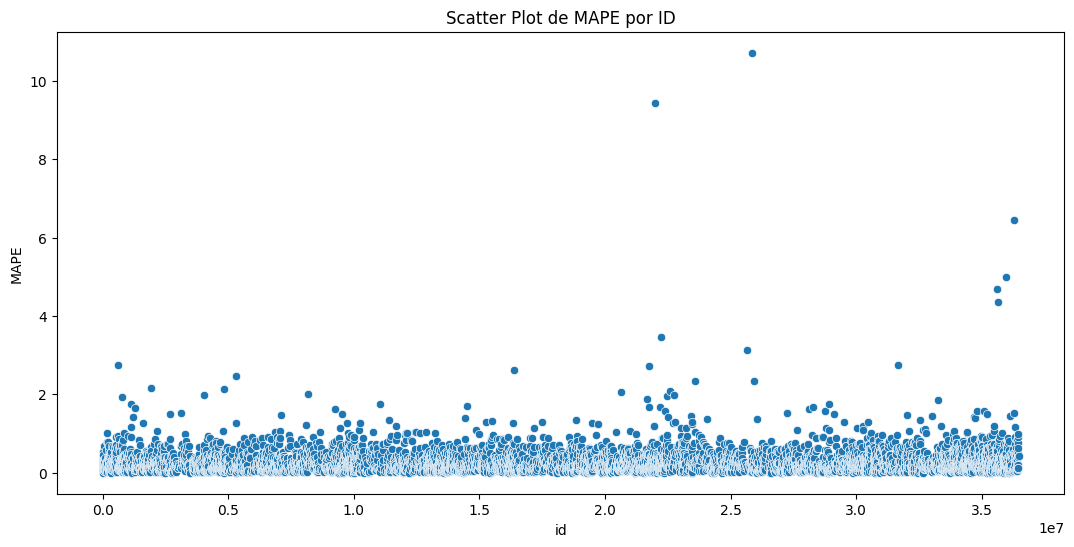

In [72]:
# dropando outlier que impossibilita a visualização (mape muito alto)
aux=df92.drop(df92[df92['id'] == 21304320].index, axis=0)

# px.scatter(aux,x='id',y='MAPE',height=500)

plt.figure(figsize=(13, 6))  
sns.scatterplot(x='id', y='MAPE', data=aux)
plt.title('Scatter Plot de MAPE por ID')
plt.show()

## **9.2 Total performance**

In [33]:
df92[['price','predictions','worst_scenario','best_scenario']] = (df92[['price','predictions','worst_scenario','best_scenario']]
                                                                    .replace('[\$,]', '', regex=True).astype(float))

aux1=df92[df92['price']<=100]
aux2=df92[(df92['price']>100) & (df92['price']<=300)]
aux3=df92[(df92['price']>300) & (df92['price']<=500)]
aux4=df92[df92['price']>=500]

print(f'MAE médio de aluguéis até $100 : {round(aux1["MAE"].mean(),2)}')
print(f'MAE médio de aluguéis entre $101 a $300 : {round(aux2["MAE"].mean(),2)}')
print(f'MAE médio de aluguéis entre $301 a $500 : {round(aux3["MAE"].mean(),2)}')
print(f'MAE médio de aluguéis acima de $500 : {round(aux4["MAE"].mean(),2)}')

MAE médio de aluguéis até $100 : 20.49
MAE médio de aluguéis entre $101 a $300 : 43.95
MAE médio de aluguéis entre $301 a $500 : 167.12
MAE médio de aluguéis acima de $500 : 646.33


In [143]:
df93=(df92[['price','predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum (x),axis=0)
                                                                    .reset_index()
                                                                    .rename(columns={'index':'Scenario',0:'Values'}))
df93['Values']=df93['Values'].map('${:,.2f}'.format)
df93

Scenario       Values
0           price  $725,918.00
1     predictions  $631,498.71
2  worst_scenario  $377,504.44
3   best_scenario  $885,493.61

## **9.3 Machine learning performance**

In [144]:
df9['error']=df9['price']-df9['predictions']

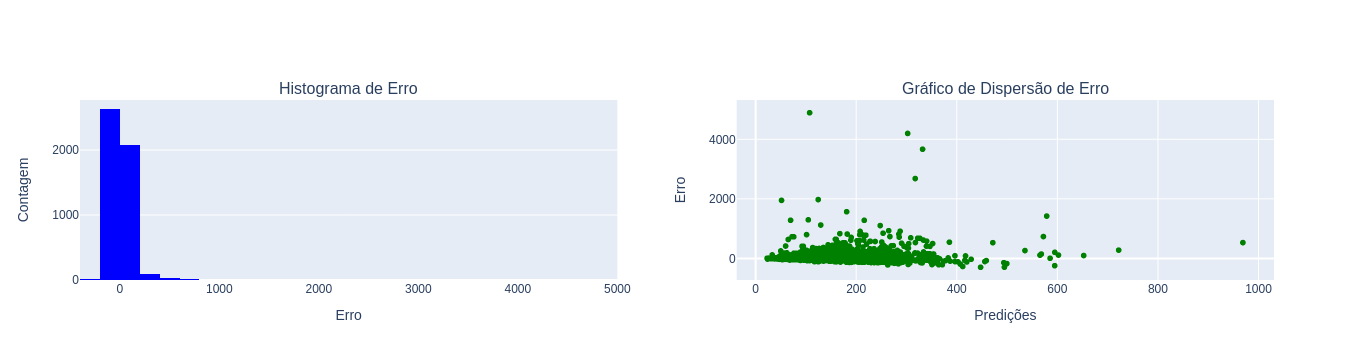

In [149]:
fig = make_subplots(rows=1, cols=2, subplot_titles=('Histograma de Erro', 'Gráfico de Dispersão de Erro'))

# adiciona o histograma
histogram_trace = px.histogram(df9, x='error', nbins=30).update_traces(marker=dict(color='blue')).data[0]
fig.add_trace(histogram_trace, row=1, col=1)
fig.update_xaxes(title_text='Erro', row=1, col=1)
fig.update_yaxes(title_text='Contagem', row=1, col=1)

# adiciona o gráfico de dispersão
scatter_trace = px.scatter(df9,x='predictions',y='error').update_traces(marker=dict(color='green')).data[0]
fig.add_trace(scatter_trace, row=1, col=2)
fig.update_xaxes(title_text='Predições', row=1, col=2)
fig.update_yaxes(title_text='Erro', row=1, col=2)

fig.update_layout(height=600, showlegend=False)

fig.show()

# **10 Entregas**

**Ver notebook look_4.0-ear-hp_tuning-error_analysis.ipynb**